# TP Compte Rendu - Systèmes de recommandation

Authors: ZHANG Bolong, ZHU Fangda

## 1 Présentation du modèle

In [45]:
import time
import scipy.sparse.linalg
import numpy as np
import scipy.optimize
from collections import namedtuple
from scipy.optimize import line_search
import matplotlib.pyplot as plt
import pdb
import scipy.optimize as OP


### Question 1.1

In [5]:
def load_movielens(filename, minidata=False):
    """
    Cette fonction lit le fichier filename de la base de donnees
    Movielens, par exemple 
    filename = '~/datasets/ml-100k/u.data'
    Elle retourne 
    R : une matrice utilisateur-item contenant les scores
    mask : une matrice valant 1 si il y a un score et 0 sinon
    """

    data = np.loadtxt(filename, dtype=int)

    R = sparse.coo_matrix((data[:, 2], (data[:, 0]-1, data[:, 1]-1)),
                          dtype=float)
    R = R.toarray()  # not optimized for big data

    # code la fonction 1_K
    mask = sparse.coo_matrix((np.ones(data[:, 2].shape),
                              (data[:, 0]-1, data[:, 1]-1)), dtype=bool )
    mask = mask.toarray()  # not optimized for big data

    if minidata is True:
        R = R[0:100, 0:200].copy()
        mask = mask[0:100, 0:200].copy()

    return R, mask

[R, mask] = utils.load_movielens("ml-100k/u.data")
Constants = namedtuple('Constants', ['R','mask', 'rho', 'Q0','V_T','C', 'beta','a','b','u','i'])
U,S,V_T = scipy.sparse.linalg.svds(R, k= 4 , which = 'LM')
u,i = R.shape
const = Constants(R, mask, 0.3, U, V_T, 4, 0.5,0.5,0.5,u,i)

const.R

array([[ 5.,  3.,  4., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

Si l'option <code> minidata </code> is true, the function <code> load_movielens</code> will return the matrice with just first 100 lignes and fisrt 200 colonne.

### Question 1.2

In [6]:
print("Number of users:%d\nNumber of films:%d" % const.R.shape)
print("Total number of note:%d" %sum(const.mask.reshape(-1)))

Number of users:943
Number of films:1682
Total number of note:100000


### Qurestion 1.3

a) cette fonction n'est pas convexee
b) Calcule gradient
$\thelta $

## 2 Trouver $P$ quand $Q_0$ est fixé

### Question 2.1
$$ \frac{\partial g}{\partial p_{m,k}} = \sum_{(u,i) \in K }(r_{u,i} - \sum_{c \in C}q_{u,c}p_{c,i})(-q_{u,k}) + \rho p_{u,k} $$
Donc le gradient par rapport P peut s'ecrit sous format ci-dessous:

$$\nabla_P G(P,Q)  =  - Q^T(\mathbb I_K \circ (R-QP)) + \rho P$$

en notant que la matrice $\nabla_p G(P,Q)$ est une matrice de taille $c \times$ i sous format ci-dessous:


$$
\nabla_P G (P,Q) = 
\begin{pmatrix}
\frac{\partial g}{\partial p_{1,1}} & \frac{\partial g}{\partial p_{1,2}}  & \dots &\dots & \frac{\partial g}{\partial p_{1,I}}\\ 
\frac{\partial g}{\partial p_{2,1}} & \frac{\partial g}{\partial p_{2,2}} & \dots	& \dots 	&\frac{\partial g}{\partial p_{2,I}} \\
\vdots&	\vdots	&\ddots					&					&\vdots \\
\vdots&	\vdots	&					&\ddots					&\vdots \\ 
\frac{\partial g}{\partial p_{C,1}} & \frac{\partial g}{\partial p_{C,2}}  & \dots &\dots & \frac{\partial g}{\partial p_{C,I}}\\ 
\end{pmatrix}
$$



De même façon, on peut obtenir le gradient par rapport à P peut s'écrit sous format ci-dessous:

$$ \frac{\partial g}{\partial q_{m,l}} = \sum_{(u,i) \in K }(r_{u,i} - \sum_{c \in C}q_{u,c}p_{c,i})(-q_{l,i}) + \rho q_{m,l} $$

D'où

$$\nabla_Q G(P,Q)  =  -(\mathbb I_K \circ (R-QP))P^T + \rho P$$










### Question 2.2

In [8]:
def objective(P, Q0, R, mask, rho):
    """
    La fonction objectif du probleme simplifie.
    Prend en entree 
    P : la variable matricielle de taille C x I
    Q0 : une matrice de taille U x C
    R : une matrice de taille U x I
    mask : une matrice 0-1 de taille U x I
    rho : un reel positif ou nul

    Sorties :
    val : la valeur de la fonction
    grad_P : le gradient par rapport a P
    """

    tmp = (R - Q0.dot(P)) * mask

    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q0 ** 2) + np.sum(P ** 2))

    grad_P = -Q0.T.dot(tmp) + rho * P  # todo

    return val, grad_P    

rho = 0.5
C = 4
u,i = R.shape

objective(V_T, U, R, mask, rho)[1].shape

(4, 1682)

In [9]:
[R, mask] = utils.load_movielens("ml-100k/u.data")
rho = 0.3
Q0,S,V_T = scipy.sparse.linalg.svds(R, k= 4 , which = 'LM')

def obj_Q_fix(P):
    return objective(P, const.Q0, const.R, const.mask, const.rho)

def funcObj(P_vec):
    P = P_vec.reshape(const.C,const.i)
    return obj_Q_fix(P)[0]

def funcGrad(P_vec):
    P = P_vec.reshape(const.C,const.i)
    func_grad = obj_Q_fix(P)[1]
    return np.ravel(func_grad)

In [10]:
t0 = time.time()

diff = scipy.optimize.check_grad(funcObj, funcGrad, np.ravel(V_T))

print("The difference of gradient is %f" % diff)
print("Done in %0.3fs." % (time.time()-t0))

The difference of gradient is 0.979345
Done in 222.559s.


### Question 2.3 Minimiser une fonction g par la méthode du gradient.

In [11]:
def gradient(P0, gamma, epsilon):
    """
    Implémenter la méthode du gradient avec gamma constante
    g : fonction objectif à minimiser
    P : le point depart à minimiser
    gamma : le pas en partant du point initial P0
    epsilon : le critère d'arrêt
    
    Sorties :
    val : la valeur de la fonction au point minimal
    P : le point arrivant au minimal
    cnt : nombre de l'itération
    """
    P = P0
    val,diff = obj_Q_fix(P)
    cnt = 0
    while(np.sum(diff**2) > epsilon**2):
        P = P - gamma * diff
        val, diff = obj_Q_fix(P)
        cnt = cnt + 1

    return val, P, cnt  

### Question 2.4 minimiser la fonction g jusqu’à la précision ϵ = 1

In [12]:
t0 = time.time()
L = const.rho + np.sqrt(np.sum(const.Q0**2))

val_grad, sn_grad , cnt_grad = gradient(np.zeros_like(const.V_T), gamma = 1.0/L, epsilon = 1)
t_grad = time.time() - t0

print("The minimal value of target function: %f" %val_grad )
print("The solution:",sn_grad)
print("Number of iteration: %d" %cnt_grad)
print("using time: %f" %t_grad)

The minimal value of target function: 369551.549755
The solution: [[ -2.23284052e+00   4.90628311e-01   9.98905148e+00 ...,  -4.74964920e-01
    3.92192583e-02   8.67767872e-01]
 [  4.53777216e+00  -1.35363756e+01  -2.56780390e+00 ...,   3.63521640e-01
   -3.15383271e-01  -1.77450057e-01]
 [ -2.02978116e+01  -4.68311514e-01  -1.07452637e+01 ...,  -3.43492982e-01
    8.20978821e-02   1.54994809e-01]
 [  5.76416721e+01   2.77455297e+01   1.98641954e+01 ...,   6.09193469e-02
    6.75805988e-01   6.32539852e-01]]
Number of iteration: 26
using time: 0.839790


## 3 Raffinements algorithmiques pour le problème à $Q_0$

### Question 3.1

In [13]:
def gradient_armijo(P0, epsilon):
    """
    Implémenter la méthode du gradient avec "armijo's line search"
    g : fonction objectif à minimiser
    epsilon : le critère d'arrêt
    
    Sorties :
    val : la valeur de la fonction au point minimal
    P : le point arrivant au minimal
    cnt : nombre de l'itération
    """
    x_k = P0
    val,diff = obj_Q_fix(x_k)
    cnt = 0
    while(np.sum(diff**2) > epsilon**2):
        gamma = const.b
        x_plus = x_k - gamma * diff
        val_plus, diff_plus = obj_Q_fix(x_plus)
        diff_square = np.sum(diff**2)
        while(val_plus > val - const.beta * gamma * diff_square):
            gamma = gamma*const.a
            x_plus = x_k - gamma* diff
            val_plus, diff_plus = obj_Q_fix(x_plus)
        
        diff_square = np.sum(diff**2)
        diff = diff_plus
        x_k = x_plus
        val = val_plus
        cnt = cnt + 1

    return val, x_k, cnt


In [14]:
t0 = time.time()
L = const.rho + np.sqrt(np.sum(const.Q0**2))

val_ar, sn_ar , cnt_ar = gradient_armijo(np.zeros_like(const.V_T),  epsilon = 1)
t_ar = time.time() - t0

print("The minimal value of target function: %f" %val_ar )
print("The solution:",sn_ar)
print("Number of iteration: %d" %cnt_ar )
print("using time: %f" %t_ar)

The minimal value of target function: 369551.666531
The solution: [[ -2.23288869e+00   4.90833877e-01   9.99075882e+00 ...,  -4.74299488e-01
    3.91599840e-02   8.66576415e-01]
 [  4.53782257e+00  -1.35373214e+01  -2.56895974e+00 ...,   3.63012341e-01
   -3.14906614e-01  -1.77206416e-01]
 [ -2.02978359e+01  -4.68054805e-01  -1.07449594e+01 ...,  -3.43011744e-01
    8.19738029e-02   1.54781999e-01]
 [  5.76416922e+01   2.77448767e+01   1.98627950e+01 ...,   6.08339981e-02
    6.74784604e-01   6.31671366e-01]]
Number of iteration: 22
using time: 0.720940


In [15]:
%lprun -f gradient_armijo gradient_armijo(np.zeros_like(const.V_T),  epsilon = 1)

ERROR:root:Line magic function `%lprun` not found.


### question 3.2

In [16]:
%reload_ext line_profiler
%lprun

def method_conjugue(P0, epsilon):
    P = P0
    val, diff = obj_Q_fix(P0)
    dk = -diff
    k = 0
    
    while(np.sum(diff**2) > epsilon**2):
        sk,fc, gc, new_fval, old_fval,new_slope = line_search(funcObj, 
                                                              funcGrad, 
                                                              xk = np.ravel(P), 
                                                              pk = np.ravel(dk), c1=0.5 )
        P = P + sk * dk
        diff_new = new_slope.reshape(const.C, const.i)
        bk = np.sum(diff_new**2) / np.sum(diff**2)
        dk = -diff_new + bk * dk
        k = k+1
        diff = diff_new
        val = new_fval
    return val, P, k

In [17]:
t0 = time.time()
val_conj, sn_conj ,cnt_conj = method_conjugue(np.zeros_like(const.V_T), 1)
t_conj = time.time() - t0


print("The minimal value of target function: %f" %val_conj )
print("The solution:",sn_conj)
print("Number of iteration: %d" %cnt_conj)
print("using time: %f" %t_conj)

The minimal value of target function: 369551.406611
The solution: [[ -2.20900327e+00   4.87132979e-01   9.95549972e+00 ...,  -4.72993282e-01
    3.89993039e-02   8.64483226e-01]
 [  4.53963698e+00  -1.35168869e+01  -2.54449475e+00 ...,   3.62012616e-01
   -3.13614499e-01  -1.76778379e-01]
 [ -2.02757600e+01  -4.49058146e-01  -1.07436239e+01 ...,  -3.42067100e-01
    8.16374504e-02   1.54408128e-01]
 [  5.76172961e+01   2.77696619e+01   1.98602070e+01 ...,   6.06664632e-02
    6.72015848e-01   6.30145583e-01]]
Number of iteration: 7
using time: 0.923955


### Question 3.3 Comparer les perfomances des trois algorithmes

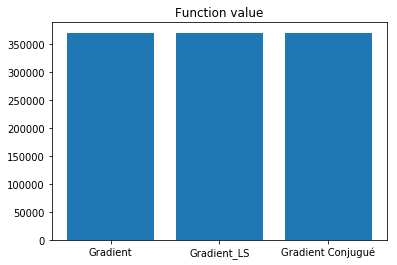

In [18]:
x = np.arange(3)
val = [val_grad, val_ar, val_conj]
t_use = [t_grad, t_ar, t_conj]
cnt = [cnt_grad, cnt_ar, cnt_conj]
legends = ("Gradient", "Gradient_LS", "Gradient Conjugué")

plt.bar(x, val)
plt.xticks(x,legends)
plt.title("Function value")
plt.show()

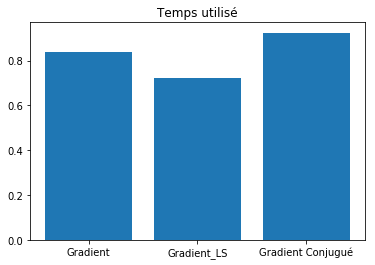

In [19]:
plt.bar(x, t_use)
plt.xticks(x,legends)
plt.title("Temps utilisé")
plt.show()

## 4 Résoudre du problème complet

### Question 4.1

In [20]:
def total_objective(P, Q, R, mask, rho):
    """
    La fonction objectif du probleme complet.
    Prend en entree 
    P : la variable matricielle de taille C x I
    Q : la variable matricielle de taille U x C
    R : une matrice de taille U x I
    mask : une matrice 0-1 de taille U x I
    rho : un reel positif ou nul

    Sorties :
    val : la valeur de la fonction
    grad_P : le gradient par rapport a P
    grad_Q : le gradient par rapport a Q
    """

    tmp = (R - Q.dot(P)) * mask

    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q ** 2) + np.sum(P ** 2))

    grad_P = -Q.T.dot(tmp) + const.rho * P

    grad_Q = -tmp.dot(P.T) + const.rho * Q  # todo

    return val, grad_P, grad_Q

def total_objective_vectorized(PQvec, R, mask, rho):
    """
    Vectorisation de la fonction precedente de maniere a ne pas
    recoder la fonction gradient
    """

    # reconstruction de P et Q
    n_items = R.shape[1]
    n_users = R.shape[0]
    F = int(PQvec.shape[0] / (n_items + n_users))
    Pvec = PQvec[0:n_items*F]
    Qvec = PQvec[n_items*F:]
    P = np.reshape(Pvec, (F, n_items))
    Q = np.reshape(Qvec, (n_users, F))

    val, grad_P, grad_Q = total_objective(P, Q, R, mask, rho)
    return val, np.concatenate([grad_P.ravel(), grad_Q.ravel()])

def total_line_search_armijo(func, PQvec, R,mask, rho, a, b, beta):
    gamma = b
    val, diff = func(PQvec, R, mask, rho)
    diff_square = np.sum(diff**2)
    x_plus =PQvec - gamma * diff
    val_plus = func(x_plus, R, mask, rho)[0]
    while(val_plus > val - beta * gamma * diff_square):
        gamma = gamma * a
        x_plus = PQvec - gamma * diff
        val_plus = func(x_plus, R, mask, rho)[0] 
    return gamma

In [21]:
def gradient_method_complet(PQvec, R, mask, rho,epsilon):
    """
    Implémenter la méthode du gradient avec gamma constante
    PQvec : le point depart à minimiser
    epsilon : le critère d'arrêt
    
    Sorties :
    val : la valeur de la fonction au point minimal
    P : le point arrivant au minimal
    cnt : nombre de l'itération
    """
    xk = PQvec
    val, diff = total_objective_vectorized(PQvec, R, mask, rho)
    cnt = 0
    while(np.sum(diff**2) > epsilon**2):
        gamma = total_line_search_armijo(total_objective_vectorized,xk,R,mask,rho,0.5,0.5,0.5)
        xk = xk - gamma * diff
        val, diff = total_objective_vectorized(xk, R, mask, rho)
        cnt = cnt + 1

    return val, xk ,cnt  

In [22]:
t0 = time.time()
PQvec = np.append(const.V_T.ravel(),const.Q0.ravel())
val_cplt, sn_cplt, cnt_cplt = gradient_method_complet(PQvec,const.R, const.mask, const.rho, 100)
t_cplt = time.time() - t0


print("The minimal value of target function: %f" %val_cplt )
print("The solution:",sn_cplt)
print("Number of iteration: %d" %cnt_cplt)
print("using time: %f" %t_cplt)


The minimal value of target function: 35970.726746
The solution: [-0.31478848  0.02472654  0.81959663 ..., -0.32198861 -0.81514573
  2.00904794]
Number of iteration: 93
using time: 36.645028


### Question 4.3

In [23]:
def func_pure(P,Q,R,mask, rho):
    tmp = (R - Q.dot(P)) * mask
    return np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q ** 2) + np.sum(P ** 2))
    
def my_line_search(func, x, d,b, *args):
    ''' chercher un gamma qui se fait le func(x+gamma*d) arriver au point minimal
    '''
    gamma = 2*b
    x_plus = x + gamma * d
    val = func(x, *args)
    val_plus = func(x_plus, *args)
    #nbIt = 0
    d_square = np.sum(d**2)
    while(val_plus > val - const.beta * gamma * d_square):
        #print('val_plus',val_plus,'val-?',  const.beta * gamma * d_square)
        gamma = gamma*const.a
        x_plus = x + gamma* d
        val_plus = func(x_plus, *args)
        #print("gamma",gamma,'val_plus',val_plus,val - const.beta * gamma * np.sum(d.ravel()*(x_plus - x).ravel()))
        #nbIt = nbIt + 1
    return gamma
def total_obj_vec_gra(Pvec, Qvec, R, mask, rho):
    """
    Vectorisation de la fonction precedente de maniere a ne pas
    recoder la fonction gradient
    """

    # reconstruction de P et Q
    n_items = R.shape[1]
    n_users = R.shape[0]
    F = int(PQvec.shape[0] / (n_items + n_users))
    Pvec = PQvec[0:n_items*F]
    Qvec = PQvec[n_items*F:]
    P = np.reshape(Pvec, (F, n_items))
    Q = np.reshape(Qvec, (n_users, F))
    
    val, grad_P, grad_Q = total_objective(P, Q, R, mask, rho)
    return val, grad_P.ravel(), grad_Q.ravel()
    
    
def gradient_armijo_Q_fix(P0,Q0,epsilon, *args):
    """
    Implémenter la méthode du gradient avec "armijo's line search"
    g : fonction objectif à minimiser
    epsilon : le critère d'arrêt
    
    Sorties :
    val : la valeur de la fonction au point minimal
    P : le point arrivant au minimal
    cnt : nombre de l'itération
    """
    x_k = P0
    L = const.rho + np.sqrt(np.sum(Q0**2))
    val,diff_p, diff_q = total_objective(x_k, Q0, *args)
    cnt = 0
    while(np.sum(diff_p**2) > epsilon**2):
        gamma = my_line_search(lambda x,*args:total_objective(x,Q0,*args)[0],
                            x_k,
                            -diff_p,
                            1/L,
                            *args)
#         gamma = my_line_search(lambda x,*args:func_pure(x,Q0,*args),
#                             x_k,
#                             -diff_p,
#                             1/L,
#                             *args) 
#       
#         gamma = OP.line_search(lambda x,*args:total_obj_vec_gra(x,Q0.ravel,*args)[0],
#                               lambda x,*args:total_obj_vec_gra(x,Q0.ravel,*args)[1],
#                               x_k.ravel(),
#                               -diff_p.ravel(),
#                               args = args)[0]
        x_k = x_k - gamma * diff_p
        val, diff_p, diff_q = total_objective(x_k, Q0,*args);
        cnt = cnt + 1
        #print('val', val, 'diff',np.sum(diff_p**2))
    
    return val, x_k, cnt

def gradient_armijo_P_fix(P0,Q0,epsilon, *args):
    """
    Implémenter la méthode du gradient avec "armijo's line search"
    g : fonction objectif à minimiser
    epsilon : le critère d'arrêt
    
    Sorties :
    val : la valeur de la fonction au point minimal
    P : le point arrivant au minimal
    cnt : nombre de l'itération
    """
    x_k = Q0
    val,diff_p, diff_q = total_objective(P0, x_k, *args)
    cnt = 0
    L = const.rho + np.sqrt(np.sum(P0**2))
    while(np.sum(diff_q**2) > epsilon**2):
        gamma = my_line_search(lambda x,*args:total_objective(P0,x,*args)[0],
                            x_k,
                            -diff_q,
                            1/L,
                            *args)

#         gamma = my_line_search(lambda x,*args:func_pure(P0,x,*args),
#                     x_k,
#                     -diff_q,
#                     1/L,
#                     *args)
#         gamma = OP.line_search(lambda x,*args:total_obj_vec_gra(P0.ravel,x,*args)[0],
#                               lambda x,*args:total_obj_vec_gra(P0.ravel,x,*args)[2],
#                                x_k.reval(),
#                               -diff_q.reval(),
#                               args = args)[0]
        x_k = x_k - gamma * diff_q
        val, diff_p, diff_q = total_objective(P0, x_k,*args);
        cnt = cnt + 1
        #print("--val",val, 'diff', np.sum(diff_q**2))
    return val, x_k, cnt


def ALS(P0,Q0, epsilon, *args):
    P = P0
    Q = Q0
    cnt = 0
    val,diff_p, diff_q = total_objective(P,Q,*args)
    old_val = val
    val = 0
    while(old_val != val):
        old_val = val
        Q = gradient_armijo_P_fix(P,Q, epsilon, *args)[1]
        #print('P')
        P = gradient_armijo_Q_fix(P,Q, epsilon, *args)[1]
        #print('Q')
        val,diff_p, diff_q = total_objective(P,Q,*args)
        cnt = cnt + 1
    return val, P, Q, cnt

In [44]:
t0 = time.time()
L = const.rho + np.sqrt(np.sum(const.Q0**2))

%prun
val_ar_200, sn_arp_200 ,sn_arq_200, cnt_ar_200 = ALS(const.V_T, const.Q0,500,
                                               const.R, const.mask,
                                               const.rho)

t_ar_200 = time.time() - t0

print("The minimal value of target function: %f" %val_ar_200 )
print("The solution:",sn_ar_200)
print("using time: %f" %t_ar_200)

 The minimal value of target function: 112396.498777


NameError: name 'sn_ar_200' is not defined

In [25]:
t0 = time.time()
L = const.rho + np.sqrt(np.sum(const.Q0**2))

%prun
val_ar, sn_arp ,sn_arq, cnt_ar = ALS(const.V_T, const.Q0,100,
                                               const.R, const.mask,
                                               const.rho)

t_ar = time.time() - t0

print("The minimal value of target function: %f" %val_ar )
print("The solution:",sn_ar)
print("Number of iteration: %d" %cnt_ar )
print("using time: %f s" %t_ar)

 The minimal value of target function: 50454.175757
The solution: [[ -2.23288869e+00   4.90833877e-01   9.99075882e+00 ...,  -4.74299488e-01
    3.91599840e-02   8.66576415e-01]
 [  4.53782257e+00  -1.35373214e+01  -2.56895974e+00 ...,   3.63012341e-01
   -3.14906614e-01  -1.77206416e-01]
 [ -2.02978359e+01  -4.68054805e-01  -1.07449594e+01 ...,  -3.43011744e-01
    8.19738029e-02   1.54781999e-01]
 [  5.76416922e+01   2.77448767e+01   1.98627950e+01 ...,   6.08339981e-02
    6.74784604e-01   6.31671366e-01]]
Number of iteration: 29
using time: 1997.754561


In [26]:
P = gradient_armijo_Q_fix(const.V_T,const.Q0, 100, R, mask, rho)[1]
%lprun -f my_line_search ALS(const.V_T, const.Q0,100,const.R, const.mask, const.rho)

*** KeyboardInterrupt exception caught in code being profiled.

### Question 4.4

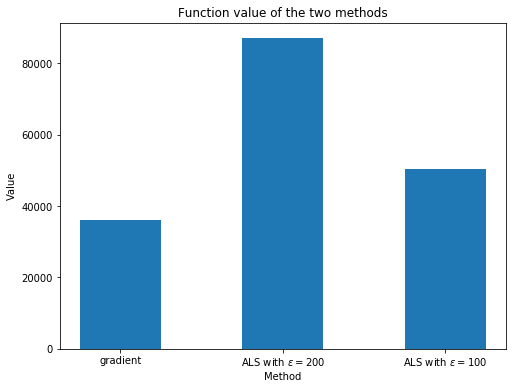

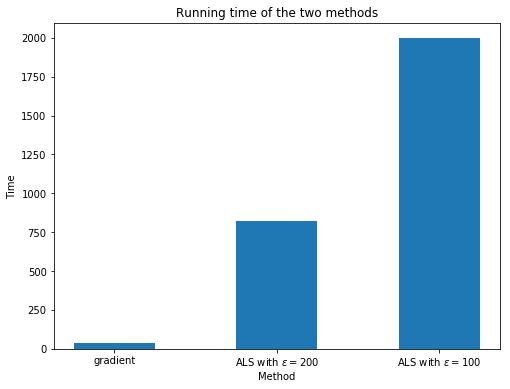

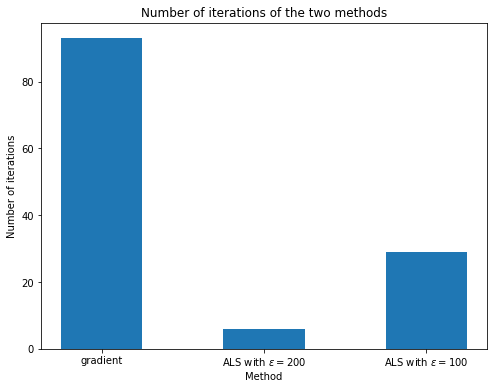

In [30]:
index = np.arange(3)
bar_width = 0.5
methods = ["gradient", "ALS with $\epsilon=200$",'ALS with $\epsilon=100$']
times = [t_cplt, t_ar_200,t_ar]
values = [val_cplt, val_ar_200, val_ar]
cnts = [cnt_cplt, cnt_ar_200, cnt_ar]

plt.figure(6, figsize=(8,6))
plt.title("Function value of the two methods")
plt.bar(index, values, bar_width)
plt.xticks(index, methods)
plt.xlabel("Method")
plt.ylabel("Value")
plt.show()

plt.figure(7, figsize=(8,6))
plt.title("Running time of the two methods")
plt.bar(index, times, bar_width)
plt.xticks(index, methods)
plt.xlabel("Method")
plt.ylabel("Time")
plt.show()

plt.figure(8, figsize=(8,6))
plt.title("Number of iterations of the two methods")
plt.bar(index, cnts, bar_width)
plt.xticks(index, methods)
plt.xlabel("Method")
plt.ylabel("Number of iterations")
plt.show()

### Question 4.5

In [41]:

# Analyser le resultat venant de méthode de gradient
U,I = const.R.shape
P_grad_cplt = sn_cplt[0:I*4 ].reshape(const.C, I)
Q_grad_cplt = sn_cplt[I*4:].reshape(U, const.C)
R_gra_cplt =  Q_grad_cplt.dot(P_grad_cplt)
score_cplt = R_gra_cplt[499,:]
indice = (-score_cplt).argsort()

print("-----------------------------------------------------------------------")
print("By gradient method, the 10 favorite films of user 449 will be:")
for i in range(10):
    print("%d: movie %d, score %f" % (i+1, indice[i], score_cplt[indice[i]]))
    
# Analyser le resultat venant de méthode des moindres carrés altérnés
U,I = const.R.shape
R_ar =sn_arq.dot(sn_arp)
score_ar = R_ar[499,:]
indice_ar = (-score_ar).argsort()

print("-----------------------------------------------------------------------")
print("By gradient method, the 10 favorite films of user 449 will be:")
for i in range(10):
    print("%d: movie %d, score %f" % (i+1, indice_ar[i], score_ar[indice_ar[i]]))

-----------------------------------------------------------------------
By gradient method, the 10 favorite films of user 449 will be:
1: movie 55, score 4.866198
2: movie 126, score 4.763520
3: movie 113, score 4.707142
4: movie 155, score 4.681151
5: movie 407, score 4.675673
6: movie 168, score 4.645976
7: movie 474, score 4.628444
8: movie 11, score 4.609943
9: movie 178, score 4.553284
10: movie 319, score 4.513413
-----------------------------------------------------------------------
By gradient method, the 10 favorite films of user 449 will be:
1: movie 1346, score 6.137047
2: movie 1374, score 5.464391
3: movie 1301, score 5.437554
4: movie 1642, score 5.333889
5: movie 1357, score 5.329185
6: movie 1430, score 5.288746
7: movie 1366, score 5.274093
8: movie 1395, score 5.161594
9: movie 1158, score 5.138227
10: movie 1462, score 5.013151
